In [ ]:
import ee
import geemap
import os
import glob
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from PIL import Image

In [1]:
# !pip install earthengine-api geemap
# #4/1AVMBsJhEUW50W5j0sVVKEQKnJHK2h4SG5vB6cDYpISAxN6QXzvhYVYsPjho

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ------------------ --------------------- 1.0/2.3 MB 5.0 MB/s eta 0:00:01
   ------------------------------------ --- 2.1/2.3 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 4.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/13.7 MB ? eta -:--:--
   ----- ---------------------------------- 1.8/13.7 MB 10.1 MB/s eta 0:00:02
   ---------- ----------------------------- 3.7/13.7 MB 9.5 MB/s eta 0:00:02
   ---------------- ----------------------- 5.8/13.7 MB 9.8 MB/s eta 0:00:01
   ---------------------- ----------------- 7.9/13.7 MB 9.9 MB/s eta 0:00:01
   -------------------------- ------------- 8.9/13.7 MB 9.1 MB/s eta 0:00:01
   ----------------------------- ---------- 10.0/13.7 MB 8.3 MB/s eta 0:00:01
   -------------------------------- ------- 11.0/13.7 MB 7.7 MB/s e


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# ee.Authenticate()
# ee.Initialize()


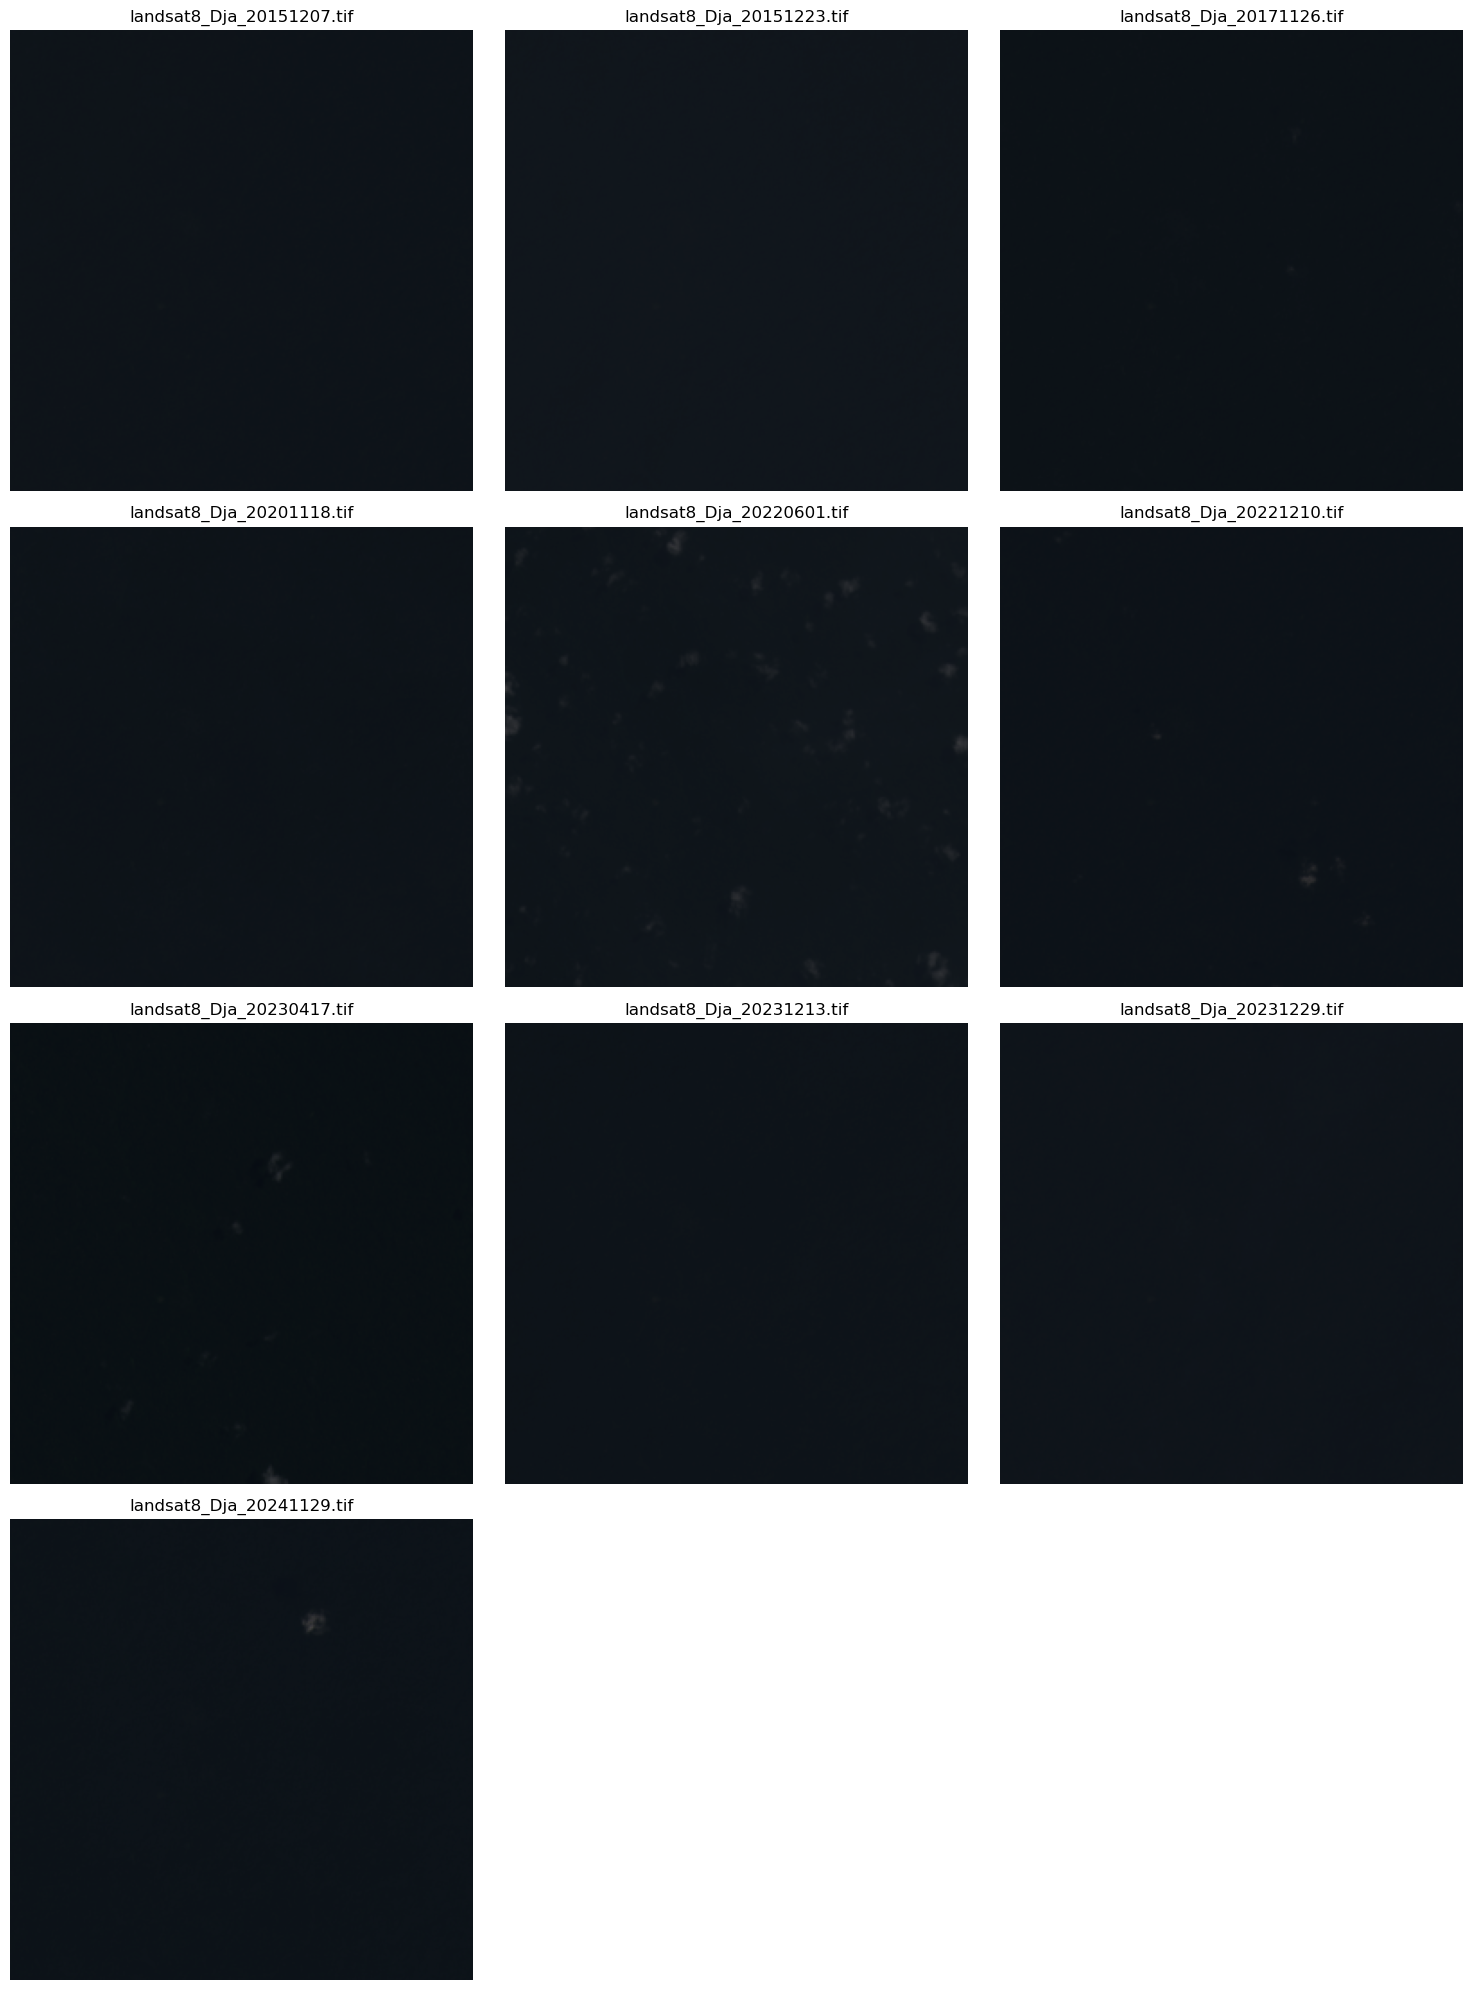

In [10]:


# # List the downloaded Landsat TIFF files
# files = sorted(glob.glob('landsat8_Dja_*.tif'))

# # Set up display grid
# n = len(files)
# cols = 3
# rows = (n + cols - 1) // cols
# plt.figure(figsize=(15, 5 * rows))

# # Loop through files and plot RGB composite
# for i, fp in enumerate(files):
#     with rasterio.open(fp) as src:
#         # Bands: 1=Blue, 2=Green, 3=Red, 4=NIR
#         blue = src.read(1)
#         green = src.read(2)
#         red = src.read(3)
#         rgb = np.dstack((red, green, blue))  # stack as R, G, B
    
#     ax = plt.subplot(rows, cols, i + 1)
#     ax.imshow(rgb)
#     ax.set_title(fp)
#     ax.axis('off')

# plt.tight_layout()
# plt.show()


In [34]:


# def stretch_band(band, lower_pct=20, upper_pct=80, clip_max=0.7):
#     """
#     Linearly stretch a band between its lower_pct and upper_pct percentiles,
#     then clip to [0, clip_max] and normalize to [0,1].
#     """
#     lo, hi = np.percentile(band, (lower_pct, upper_pct))
#     # Clip before stretch so extreme bright/cloud pixels don't dominate
#     clipped = np.clip(band, 0, clip_max)
#     stretched = (clipped - lo) / (hi - lo)
#     # Final clip to [0,1]
#     return np.clip(stretched, 0, 1)

# # List your downloaded GeoTIFFs
# files = sorted(glob.glob('landsat8_Dja_*.tif'))

# cols = 3
# rows = (len(files) + cols - 1) // cols
# plt.figure(figsize=(15, 5 * rows))

# for idx, fp in enumerate(files):
#     with rasterio.open(fp) as src:
#         blue  = src.read(1)
#         green = src.read(2)
#         red   = src.read(3)
    
#     # Stretch each band more conservatively
#     b_s = stretch_band(blue, 20, 95, clip_max=0.5)
#     g_s = stretch_band(green, 20,95, clip_max=0.5)
#     r_s = stretch_band(red, 20,95, clip_max=0.5)
    
#     rgb = np.dstack((r_s, g_s, b_s))
    
#     ax = plt.subplot(rows, cols, idx + 1)
#     ax.imshow(rgb)
#     ax.set_title(fp.split('.')[0])
#     ax.axis('off')

# plt.tight_layout()
# plt.show()


#### Downloading images

In [32]:
output_dir = os.path.join('downloaded', 'tiff_files')
os.makedirs(output_dir, exist_ok=True)

# Define ROI: 3.84 km × 3.84 km square centered at Dja Faunal Reserve (3.0° N, 13.0° E)
center_lat = 3.0
center_lon = 13.0
half_side = 3.84 / 111.0  # ~degrees for 3.84 km
roi = ee.Geometry.Rectangle([
    center_lon - half_side, center_lat - half_side,
    center_lon + half_side, center_lat + half_side
])

# Build the Landsat‑8 C2 TOA collection
collection = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
      .filterDate('2015-01-01', '2025-01-01')
      .filterBounds(roi)
      .filter(ee.Filter.lt('CLOUD_COVER', 20))
      .select(['B2', 'B3', 'B4', 'B5'])
      .sort('CLOUD_COVER')
)

# Determine number of images to download
total = collection.size().getInfo()
num_images = min(50, total)
if num_images == 0:
    raise ValueError("No images found for these criteria. Try adjusting filters.")

# Convert to list and loop
image_list = collection.toList(num_images)
for i in range(num_images):
    img = ee.Image(image_list.get(i))
    meta = img.getInfo().get('properties', {})
    timestamp = meta.get('system:time_start')
    date_str = ee.Date(timestamp).format('YYYYMMdd').getInfo()
    # Construct filepath within downloaded/tiff_files
    filename = os.path.join(output_dir, f'landsat8_Dja_{date_str}.tif')
    
    # Export to local via geemap
    geemap.ee_export_image(
        img,
        filename,
        scale=30,
        region=roi,
        file_per_band=False
    )
    
    cloud = meta.get('CLOUD_COVER')
    print(f"[{i+1}/{num_images}] Downloaded {filename} (cloud cover: {cloud}%)")

Generating URL ...
Please wait ...
Data downloaded to C:\Users\oliwa\Documents\capstone\downloaded\tiff_files\landsat8_Dja_20151223.tif
[1/17] Downloaded downloaded\tiff_files\landsat8_Dja_20151223.tif (cloud cover: 0%)
Generating URL ...
Please wait ...
Data downloaded to C:\Users\oliwa\Documents\capstone\downloaded\tiff_files\landsat8_Dja_20241129.tif
[2/17] Downloaded downloaded\tiff_files\landsat8_Dja_20241129.tif (cloud cover: 1.96%)
Generating URL ...
Please wait ...
Data downloaded to C:\Users\oliwa\Documents\capstone\downloaded\tiff_files\landsat8_Dja_20221210.tif
[3/17] Downloaded downloaded\tiff_files\landsat8_Dja_20221210.tif (cloud cover: 2.72%)
Generating URL ...
Please wait ...
Data downloaded to C:\Users\oliwa\Documents\capstone\downloaded\tiff_files\landsat8_Dja_20201118.tif
[4/17] Downloaded downloaded\tiff_files\landsat8_Dja_20201118.tif (cloud cover: 3.5%)
Generating URL ...
Please wait ...
Data downloaded to C:\Users\oliwa\Documents\capstone\downloaded\tiff_files\la

In [35]:
output_base = os.path.join('downloaded', 'tiff_files')
os.makedirs(output_base, exist_ok=True)

# Define your regions of interest and their centers
regions = {
    'dja':       ( 3.000, 13.000),
    'minkebe':   ( 1.680, 12.760),
    'nouabele':  ( 2.467, 16.450),
    'salonga':   (-2.000, 21.000),
    'likouala':  ( 1.350, 17.150)
}

# Half‐side in degrees for ~3.84 km at the equator
half_side = 3.84 / 111.0  

# Common filter settings
start_date = '2015-01-01'
end_date   = '2025-01-01'
cloud_thresh = 20
bands = ['B2','B3','B4','B5']
max_images = 150  # per region

for name, (lat, lon) in regions.items():
    # Create a small square ROI around each center
    roi = ee.Geometry.Rectangle([
        lon - half_side, lat - half_side,
        lon + half_side, lat + half_side
    ])
    
    # Build & filter the Landsat‑8 C2 TOA collection
    col = (
        ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
          .filterDate(start_date, end_date)
          .filterBounds(roi)
          .filter(ee.Filter.lt('CLOUD_COVER', cloud_thresh))
          .select(bands)
          .sort('CLOUD_COVER')
    )
    
    # How many scenes?
    count = col.size().getInfo()
    n = min(max_images, count)
    print(f"{name}: {count} scenes found, downloading {n}")
    
    if n == 0:
        continue
    
    # Make region‐specific output folder (optional)
    out_dir = os.path.join(output_base, name)
    os.makedirs(out_dir, exist_ok=True)
    
    # Download the first n images
    img_list = col.toList(n)
    for i in range(n):
        img = ee.Image(img_list.get(i))
        props = img.getInfo()['properties']
        ts = props.get('system:time_start')
        date = ee.Date(ts).format('YYYYMMdd').getInfo()
        
        # Filename with region prefix
        fname = f"{name}_{date}.tif"
        out_fp = os.path.join(out_dir, fname)
        
        # Export to local via geemap
        geemap.ee_export_image(
            img,
            out_fp,
            scale=30,
            region=roi,
            file_per_band=False
        )
        cloud = props.get('CLOUD_COVER')
        print(f"  ▶ {fname} (cloud: {cloud}%)")

dja: 17 scenes found, downloading 17
Generating URL ...
Please wait ...
Data downloaded to C:\Users\oliwa\Documents\capstone\downloaded\tiff_files\dja\dja_20151223.tif
  ▶ dja_20151223.tif (cloud: 0%)
Generating URL ...
Please wait ...
Data downloaded to C:\Users\oliwa\Documents\capstone\downloaded\tiff_files\dja\dja_20241129.tif
  ▶ dja_20241129.tif (cloud: 1.96%)
Generating URL ...
Please wait ...
Data downloaded to C:\Users\oliwa\Documents\capstone\downloaded\tiff_files\dja\dja_20221210.tif
  ▶ dja_20221210.tif (cloud: 2.72%)
Generating URL ...
Please wait ...
Data downloaded to C:\Users\oliwa\Documents\capstone\downloaded\tiff_files\dja\dja_20201118.tif
  ▶ dja_20201118.tif (cloud: 3.5%)
Generating URL ...
Please wait ...
Data downloaded to C:\Users\oliwa\Documents\capstone\downloaded\tiff_files\dja\dja_20151207.tif
  ▶ dja_20151207.tif (cloud: 4.3%)
Generating URL ...
Please wait ...
Data downloaded to C:\Users\oliwa\Documents\capstone\downloaded\tiff_files\dja\dja_20230417.tif
  

#### transforming and saving images as png files

In [36]:
input_base = os.path.join("downloaded", "tiff_files")
output_dir = os.path.join("downloaded", "images")
os.makedirs(output_dir, exist_ok=True)

# Parameters matching the paper's visualize() settings
min_reflect = 0.0
max_reflect = 0.3
target_dim = (332, 332)

# Find all TIFFs in region subfolders
tif_files = sorted(glob.glob(os.path.join(input_base, "*", "*.tif")))

for fp in tif_files:
    # Read the three visible bands
    with rasterio.open(fp) as src:
        blue  = src.read(1)  # B2
        green = src.read(2)  # B3
        red   = src.read(3)  # B4
    
    # Stack into RGB array (R, G, B)
    rgb = np.dstack((red, green, blue)).astype(np.float32)
    
    # Clip reflectance and normalize to 0–255
    rgb = np.clip(rgb, min_reflect, max_reflect)
    rgb_scaled = ((rgb - min_reflect) / (max_reflect - min_reflect) * 255).astype(np.uint8)
    
    # Convert to PIL image and resize to 332×332
    img = Image.fromarray(rgb_scaled)
    img_resized = img.resize(target_dim, resample=Image.BILINEAR)
    
    # Save as PNG in the single images folder
    base = os.path.splitext(os.path.basename(fp))[0]  # e.g. "minkebe_20210715"
    out_fp = os.path.join(output_dir, f"{base}.png")
    img_resized.save(out_fp)
    print(f"Processed and saved {out_fp}")

Processed and saved downloaded\images\dja_20150427.png
Processed and saved downloaded\images\dja_20151207.png
Processed and saved downloaded\images\dja_20151223.png
Processed and saved downloaded\images\dja_20171126.png
Processed and saved downloaded\images\dja_20200424.png
Processed and saved downloaded\images\dja_20201118.png
Processed and saved downloaded\images\dja_20210121.png
Processed and saved downloaded\images\dja_20210529.png
Processed and saved downloaded\images\dja_20220329.png
Processed and saved downloaded\images\dja_20220601.png
Processed and saved downloaded\images\dja_20221210.png
Processed and saved downloaded\images\dja_20230417.png
Processed and saved downloaded\images\dja_20231213.png
Processed and saved downloaded\images\dja_20231229.png
Processed and saved downloaded\images\dja_20240521.png
Processed and saved downloaded\images\dja_20240708.png
Processed and saved downloaded\images\dja_20241129.png
Processed and saved downloaded\images\likouala_20150116.png
Proce

In [48]:
subtypes = ee.ImageCollection('JRC/GFC2020_subtypes/V0')
gft = subtypes.mosaic().select('Map')    # now gft is an ee.Image

# 2) Build the “primary forest” mask (class == 10)
primary_mask = gft.eq(10)

# 3) Define the Congo Basin box
basin = ee.Geometry.Rectangle([11.0, -5.0, 30.0, 5.5])

# 4) Scatter 500 random points
random_pts = ee.FeatureCollection.randomPoints(basin, 500)

# 5) Flag each point with the mask value under it
def flag_point(pt):
    vals = primary_mask.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=pt.geometry(),
        scale=30
    )
    return pt.set('isPrimary', vals.get('Map'))

flagged = random_pts.map(flag_point)

# 6) Filter to keep only primary‐forest points
primary_pts = flagged.filter(ee.Filter.eq('isPrimary', 1))

# 7) Print out how many we have
count = primary_pts.size().getInfo()
print("Total primary‐forest points:", count)

# 8) (Optional) Print first 5 for sanity
first5 = primary_pts.limit(5)
print("Example features:", first5.getInfo()['features'])

# 9) Extract the first 100 coords
coords = primary_pts.limit(1000) \
    .map(lambda f: ee.Feature(None, {
        'lon': f.geometry().coordinates().get(0),
        'lat': f.geometry().coordinates().get(1)
    })) \
    .reduceColumns(
        reducer=ee.Reducer.toList(2),
        selectors=['lon','lat']
    ) \
    .get('list') \
    .getInfo()

print("Extracted coords count:", len(coords))
for lon, lat in coords:
    print(f"({lat:.6f}, {lon:.6f})")

Total primary‐forest points: 207
Example features: [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [26.121098317638683, -0.6401504735920541]}, 'id': '2', 'properties': {'isPrimary': 1}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [28.164289011554647, 4.775844920936976]}, 'id': '3', 'properties': {'isPrimary': 1}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [12.598039855557959, -0.08730904551462175]}, 'id': '4', 'properties': {'isPrimary': 1}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [17.23170375287415, -0.1592117508163901]}, 'id': '6', 'properties': {'isPrimary': 1}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [13.140072776673222, -3.7576762348360515]}, 'id': '7', 'properties': {'isPrimary': 1}}]
Extracted coords count: 207
(-0.640150, 26.121098)
(4.775845, 28.164289)
(-0.087309, 12.598040)
(-0.159212, 17.231704)
(-3.757676, 13.140073)
(2.299338, 15.839358)
(3.220889, 22.053836)

In [47]:
len(coords)

100

In [52]:
base_dir = os.path.join('negative_class')
os.makedirs(base_dir, exist_ok=True)

# Tile half‑side (~3.84 km in degrees)
half_side = 3.84 / 111.0

# Common filter settings
start_date   = '2015-01-01'
end_date     = '2025-01-01'
cloud_thresh = 0.1
bands        = ['B2','B3','B4','B5']  # B5 will be ignored
max_images   = 1  # per location

for lon, lat in coords_list:
    # Create region directory and visible subfolder
    region_name = f"{lat:.6f}_{lon:.6f}"
    vis_dir     = os.path.join(base_dir, region_name)
    os.makedirs(vis_dir, exist_ok=True)

    # Define the square ROI
    roi = ee.Geometry.Rectangle([
        lon - half_side, lat - half_side,
        lon + half_side, lat + half_side
    ])
    
    # Filter Landsat‑8 C2 TOA collection
    col = (
        ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
          .filterDate(start_date, end_date)
          .filterBounds(roi)
          .filter(ee.Filter.lt('CLOUD_COVER', cloud_thresh))
          .select(['B4','B3','B2'])  # only RGB bands
          .sort('CLOUD_COVER')
    )
    
    # Determine how many to download
    count = col.size().getInfo()
    n = min(max_images, count)
    print(f"{region_name}: {count} scenes found, downloading {n} visible images")
    if n == 0:
        continue
    
    # Download the first n scenes (visible only)
    img_list = col.toList(n)
    for i in range(n):
        img   = ee.Image(img_list.get(i))
        props = img.getInfo()['properties']
        ts    = props.get('system:time_start')
        date  = ee.Date(ts).format('YYYYMMdd').getInfo()

        # Visible composite (RGB)
        visible = img  # already selecting B4,B3,B2 above
        out_fp  = os.path.join(vis_dir, f"{region_name}_{date}.tif")
        geemap.ee_export_image(
            visible,
            out_fp,
            scale=30,
            region=roi,
            file_per_band=False
        )

        cloud = props.get('CLOUD_COVER')
        print(f"  ▶ {date} (cloud {cloud}%) → saved to {region_name}")

3.372996_21.219212: 1 scenes found, downloading 1 visible images
Generating URL ...
Please wait ...
Data downloaded to C:\Users\oliwa\Documents\capstone\negative_class\3.372996_21.219212\3.372996_21.219212_20210611.tif
  ▶ 20210611 (cloud 0.05%) → saved to 3.372996_21.219212
-0.409973_14.225024: 0 scenes found, downloading 0 visible images
4.555220_27.249989: 15 scenes found, downloading 1 visible images
Generating URL ...
Please wait ...
Data downloaded to C:\Users\oliwa\Documents\capstone\negative_class\4.555220_27.249989\4.555220_27.249989_20150106.tif
  ▶ 20150106 (cloud 0%) → saved to 4.555220_27.249989
0.040725_16.410444: 2 scenes found, downloading 1 visible images
Generating URL ...
Please wait ...
Data downloaded to C:\Users\oliwa\Documents\capstone\negative_class\0.040725_16.410444\0.040725_16.410444_20241201.tif
  ▶ 20241201 (cloud 0%) → saved to 0.040725_16.410444
-1.397003_21.337931: 2 scenes found, downloading 1 visible images
Generating URL ...
Please wait ...
Data downl

Deleted empty folder: negative_class\-0.177616_23.357905
Deleted empty folder: negative_class\-0.223272_27.847302
Deleted empty folder: negative_class\-0.297788_12.531829
Deleted empty folder: negative_class\-0.409973_14.225024
Deleted empty folder: negative_class\-0.866165_28.168933
Deleted empty folder: negative_class\-1.244847_12.578243
Deleted empty folder: negative_class\-1.482484_28.279134
Deleted empty folder: negative_class\-1.498445_11.956185
Deleted empty folder: negative_class\-1.737902_23.174740
Deleted empty folder: negative_class\-1.814460_22.878722
Deleted empty folder: negative_class\-2.416939_11.879172
Deleted empty folder: negative_class\-3.006064_11.620146
Deleted empty folder: negative_class\-3.039858_12.957591
Deleted empty folder: negative_class\-3.200593_28.390774
Deleted empty folder: negative_class\-3.229707_11.581951
Deleted empty folder: negative_class\-3.339585_13.382903
Deleted empty folder: negative_class\-3.349320_27.432917
Deleted empty folder: negative_